In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import qnmfits
import analytic_fit
import utils
import corner

from cmcrameri import cm

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)
t0_E = pd.read_csv('../data/t0N_E.csv', index_col=0)

In [3]:
nt_min = 0
nt_max = 17
nt_list = list(range(nt_min,nt_max+1))

# Create a custom colormap
color_list = [cm.roma(N/20) for N in nt_list]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )

In [4]:
A_dict = {}
phi_dict = {}
samples_dict = {}

IDs = t0_M.keys()
ID = 1


N = 11
modes = [(2, 2, n, 1) for n in range(N+1)]
deltas = np.linspace(0,0.2,5)

# load data
sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

# perform LS fit
best_fit = qnmfits.ringdown_fit(
sim.times,
sim.h[2,2],
modes=modes+[(3,2,0,1)],
Mf=Mf,
chif=chif,
t0=t0_M[f"{ID}"][N],
t0_method='closest'
)



for mode_to_modify in range(N+1):

    A_dict[mode_to_modify] = {}
    phi_dict[mode_to_modify] = {}
    samples_dict[mode_to_modify] = {}

    for i, delta in enumerate(deltas): # loop through CCE IDs

    # load data
        sim_info = utils.load_cce_data(ID)
        sim = sim_info['sim']
        chif = sim.chif_mag
        Mf = sim.Mf

    # perform LS fit
        best_fit = qnmfits.ringdown_fit(
        sim.times,
        sim.h[2,2],
        modes=modes+[(3,2,0,1)],
        Mf=Mf,
        chif=chif,
        t0=t0_M[f"{ID}"][N],
        t0_method='closest'
    )
        A320 = np.abs(best_fit['C'])[-1]
        omega = best_fit['frequencies'][:-1]

        d = np.ones_like(omega)
        d[mode_to_modify] = 1+delta

        data = {
            'plus': np.real(sim.h[2,2]),
            'cross': -np.imag(sim.h[2,2])}
            
    # perform analytic bayesian fit
        samples, A_samples, phi_samples = analytic_fit.sample(
        times=sim.times,
        data=data,
        sigma=A320*np.ones_like(sim.times),
        qnm_omegas=omega*d,
        t0=t0_M[f"{ID}"][N],
        t0_method='closest',
        T=70,
        reweight=False,
        )
        
    # # unwrap phases
    #     unwrapped_phi_samples = phi_samples.copy()
    #     for i in range(unwrapped_phi_samples.shape[1]):
    #         unwrapped_phi_samples[:,i] = analytic_fit.unwrap(unwrapped_phi_samples[:,i])


    # save samples to dictionary
        # phi_dict[i] = unwrapped_phi_samples
        A_dict[mode_to_modify][i] = A_samples
        samples_dict[mode_to_modify][i] = samples
        


In [7]:
A_dict[0]

{0: array([[1.47898363e+00, 1.46985161e+01, 9.82965285e+01, ...,
         2.06528076e+04, 8.43631275e+03, 1.51650707e+03],
        [1.48615032e+00, 1.43928538e+01, 8.52512632e+01, ...,
         1.21773559e+04, 4.89710009e+03, 8.60836865e+02],
        [1.47797112e+00, 1.44771600e+01, 9.25558973e+01, ...,
         7.35348139e+03, 2.90328079e+03, 5.17184056e+02],
        ...,
        [1.48173932e+00, 1.42574002e+01, 8.91244794e+01, ...,
         1.17430700e+04, 4.73843151e+03, 8.45224042e+02],
        [1.47681253e+00, 1.41665896e+01, 8.33404552e+01, ...,
         1.22787395e+03, 6.86151083e+02, 1.46945134e+02],
        [1.47712758e+00, 1.44534775e+01, 9.26451607e+01, ...,
         2.84252416e+03, 7.50401483e+02, 7.44918503e+01]],
       shape=(50000, 12)),
 1: array([[1.63037605e+00, 4.04530300e+01, 5.23429340e+02, ...,
         1.81725640e+05, 7.18691259e+04, 1.25365779e+04],
        [1.63548835e+00, 4.02435655e+01, 5.16271185e+02, ...,
         1.71017350e+05, 6.72518064e+04, 1.16675885

/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_32654/3719496687.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


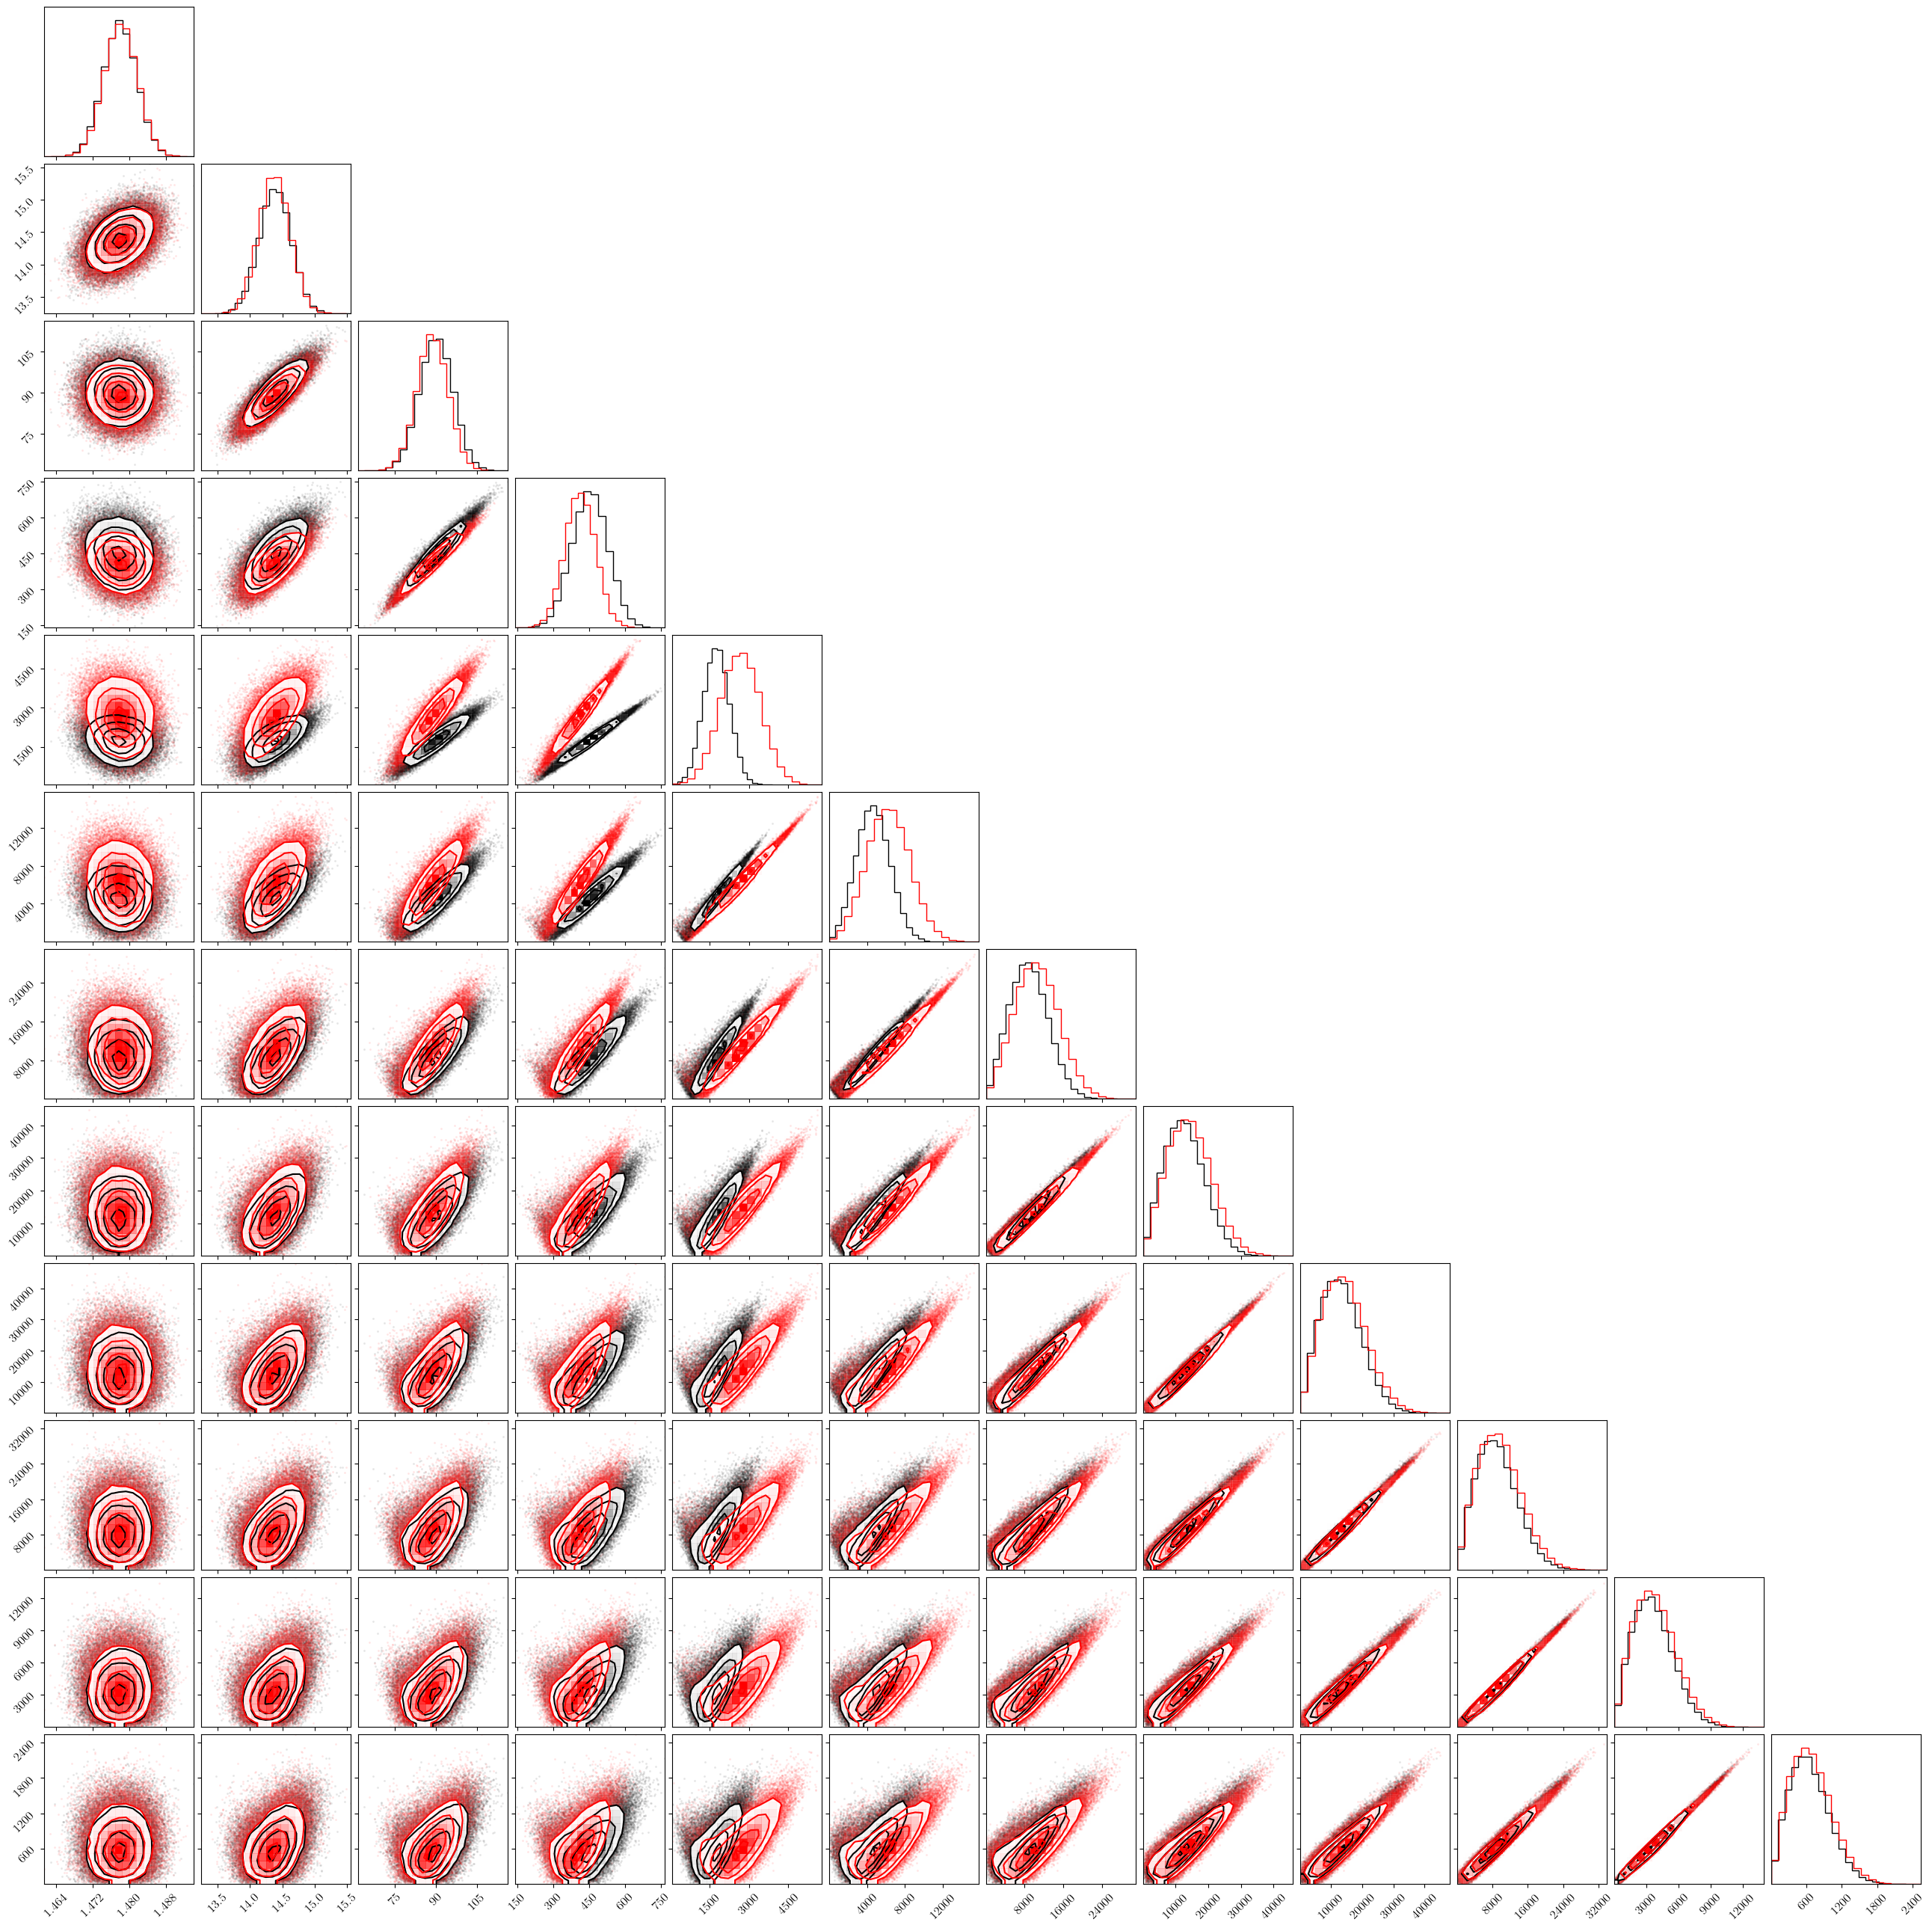

In [9]:
fig = corner.corner(A_dict[0][0])
corner.corner(A_dict[4][1], color = 'red', fig=fig)
fig.show()

Text(0.5, 0, '$\\delta$')

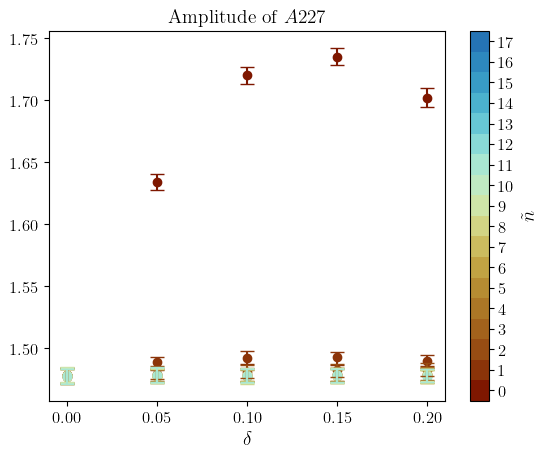

In [10]:
fig, ax = plt.subplots() 

norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'$\tilde n$'
    )

mode_to_plot = 7

for ntilde in A_dict.keys(): # iterate through mode to plot
    for key in A_dict[0].keys(): # iterate through deltas

            pdf, x = analytic_fit.A_kde(A_dict[ntilde][key][:,0])# calculate kde
            
            interval = analytic_fit.calculate_interval(pdf, x) #calculate 90% credible interval
            # build and plot error bars
            y = (interval[1]-interval[0])/2+interval[0]
            yerr = (interval[1]-interval[0])/2
            ax.errorbar(deltas[key], y,yerr=yerr, capsize = 5, color = cmap(ntilde))
            ax.scatter(deltas[key], x[np.argmax(pdf)], color=cmap(ntilde))


ax.set_title(f"Amplitude of $A22{mode_to_plot}$")
ax.set_xlabel("$\delta$")

# for a in ax:
#     a.set_ylabel("A")

/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_32654/1449557291.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0.5, 0, '$\\delta$')

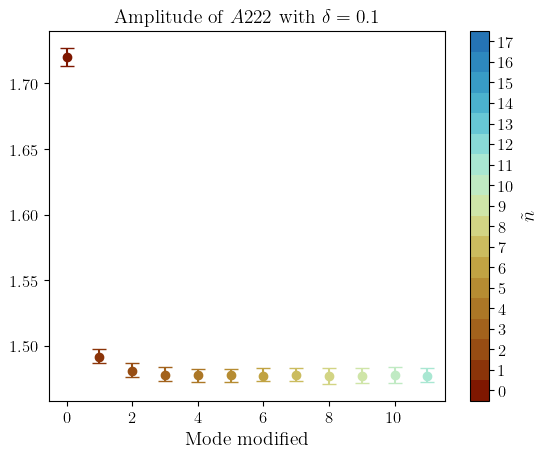

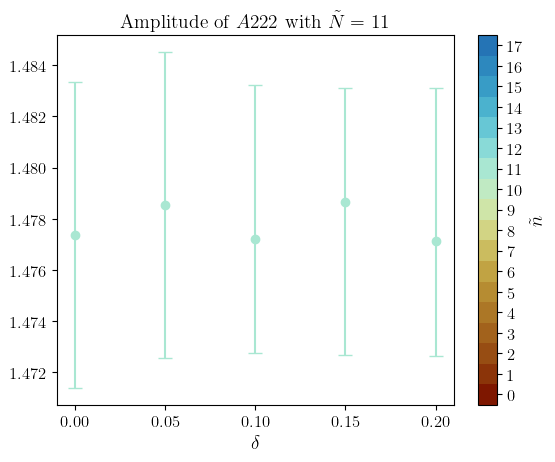

In [11]:

mode_to_plot = 2
key = 2
ntilde = 3

fig, ax = plt.subplots() 

norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'$\tilde n$'
    )



for ntilde in A_dict.keys(): # iterate through mode modified


    # for key in A_dict[0].keys(): # iterate through deltas

            pdf, x = analytic_fit.A_kde(A_dict[ntilde][key][:,0])# calculate kde
            
            interval = analytic_fit.calculate_interval(pdf, x) #calculate 90% credible interval
            # build and plot error bars
            y = (interval[1]-interval[0])/2+interval[0]
            yerr = (interval[1]-interval[0])/2
            ax.errorbar(ntilde, y,yerr=yerr, capsize = 5, color = cmap(ntilde))
            ax.scatter(ntilde, x[np.argmax(pdf)], color=cmap(ntilde))


ax.set_title(f"Amplitude of $A22{mode_to_plot}$ with $\delta={deltas[key]}$")
ax.set_xlabel("Mode modified")

fig.show()

fig, ax = plt.subplots() 

norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'$\tilde n$'
    )




for key in A_dict[0].keys(): # iterate through deltas

        pdf, x = analytic_fit.A_kde(A_dict[ntilde][key][:,0])# calculate kde
        
        interval = analytic_fit.calculate_interval(pdf, x) #calculate 90% credible interval
        # build and plot error bars
        y = (interval[1]-interval[0])/2+interval[0]
        yerr = (interval[1]-interval[0])/2
        ax.errorbar(deltas[key], y,yerr=yerr, capsize = 5, color = cmap(ntilde))
        ax.scatter(deltas[key], x[np.argmax(pdf)], color=cmap(ntilde))


ax.set_title(f"Amplitude of $A22{mode_to_plot}$ with $\\tilde N={ntilde}$")
ax.set_xlabel("$\delta$")

# for a in ax:
#     a.set_ylabel("A")